In [97]:
%pip install xgboost imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import scipy.stats.distributions as dists
import pandas as pd
import yaml

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
SUBSET = 0
EPOCH = 32
TEST_SIZE = 0.25
USE_FOURIER_COMPONENTS = False
OVER_SAMPLING = True

with open("config.yml", 'r') as f:
    config = yaml.safe_load(f)

if config is not None:
    subset_id = int(config["variables"]["dataset"]["subset"])
    PATH_TO_SUBSET = Path(config["paths"]["local"][f"subset_{SUBSET}_directory"])

    if f"subset_{SUBSET}_continuous_testing_directory" in config["paths"]["local"]:
        PATH_TO_SUBSET_CONT_TESTING = Path(
            config["paths"]["local"][f"subset_{SUBSET}_continuous_testing_directory"])
    else:
        PATH_TO_SUBSET_CONT_TESTING = PATH_TO_SUBSET
    NET_TYPE = config["variables"]["models"]["net_type"]
    IDENTIFIER = config["variables"]["models"]["net_identifier"]
else:
    subset_id = 1
    PATH_TO_SUBSET = Path(__file__).parent.joinpath("data", "subset-1")
    PATH_TO_SUBSET_CONT_TESTING = PATH_TO_SUBSET
    NET_TYPE = "UResIncNet"
    IDENTIFIER = "ks3-depth8-strided-0"

PATH_TO_META_MODEL = PATH_TO_SUBSET_CONT_TESTING.joinpath("meta-model", f"trainedOn-subset-{subset_id}",
                                                            str(NET_TYPE), str(IDENTIFIER), f"epoch-{EPOCH}")

print(NET_TYPE)
print(IDENTIFIER)

UResIncNet
ks3-depth8-layers1-strided-weightedLoss-0


(1756, 550)


<Figure size 3000x3000 with 0 Axes>

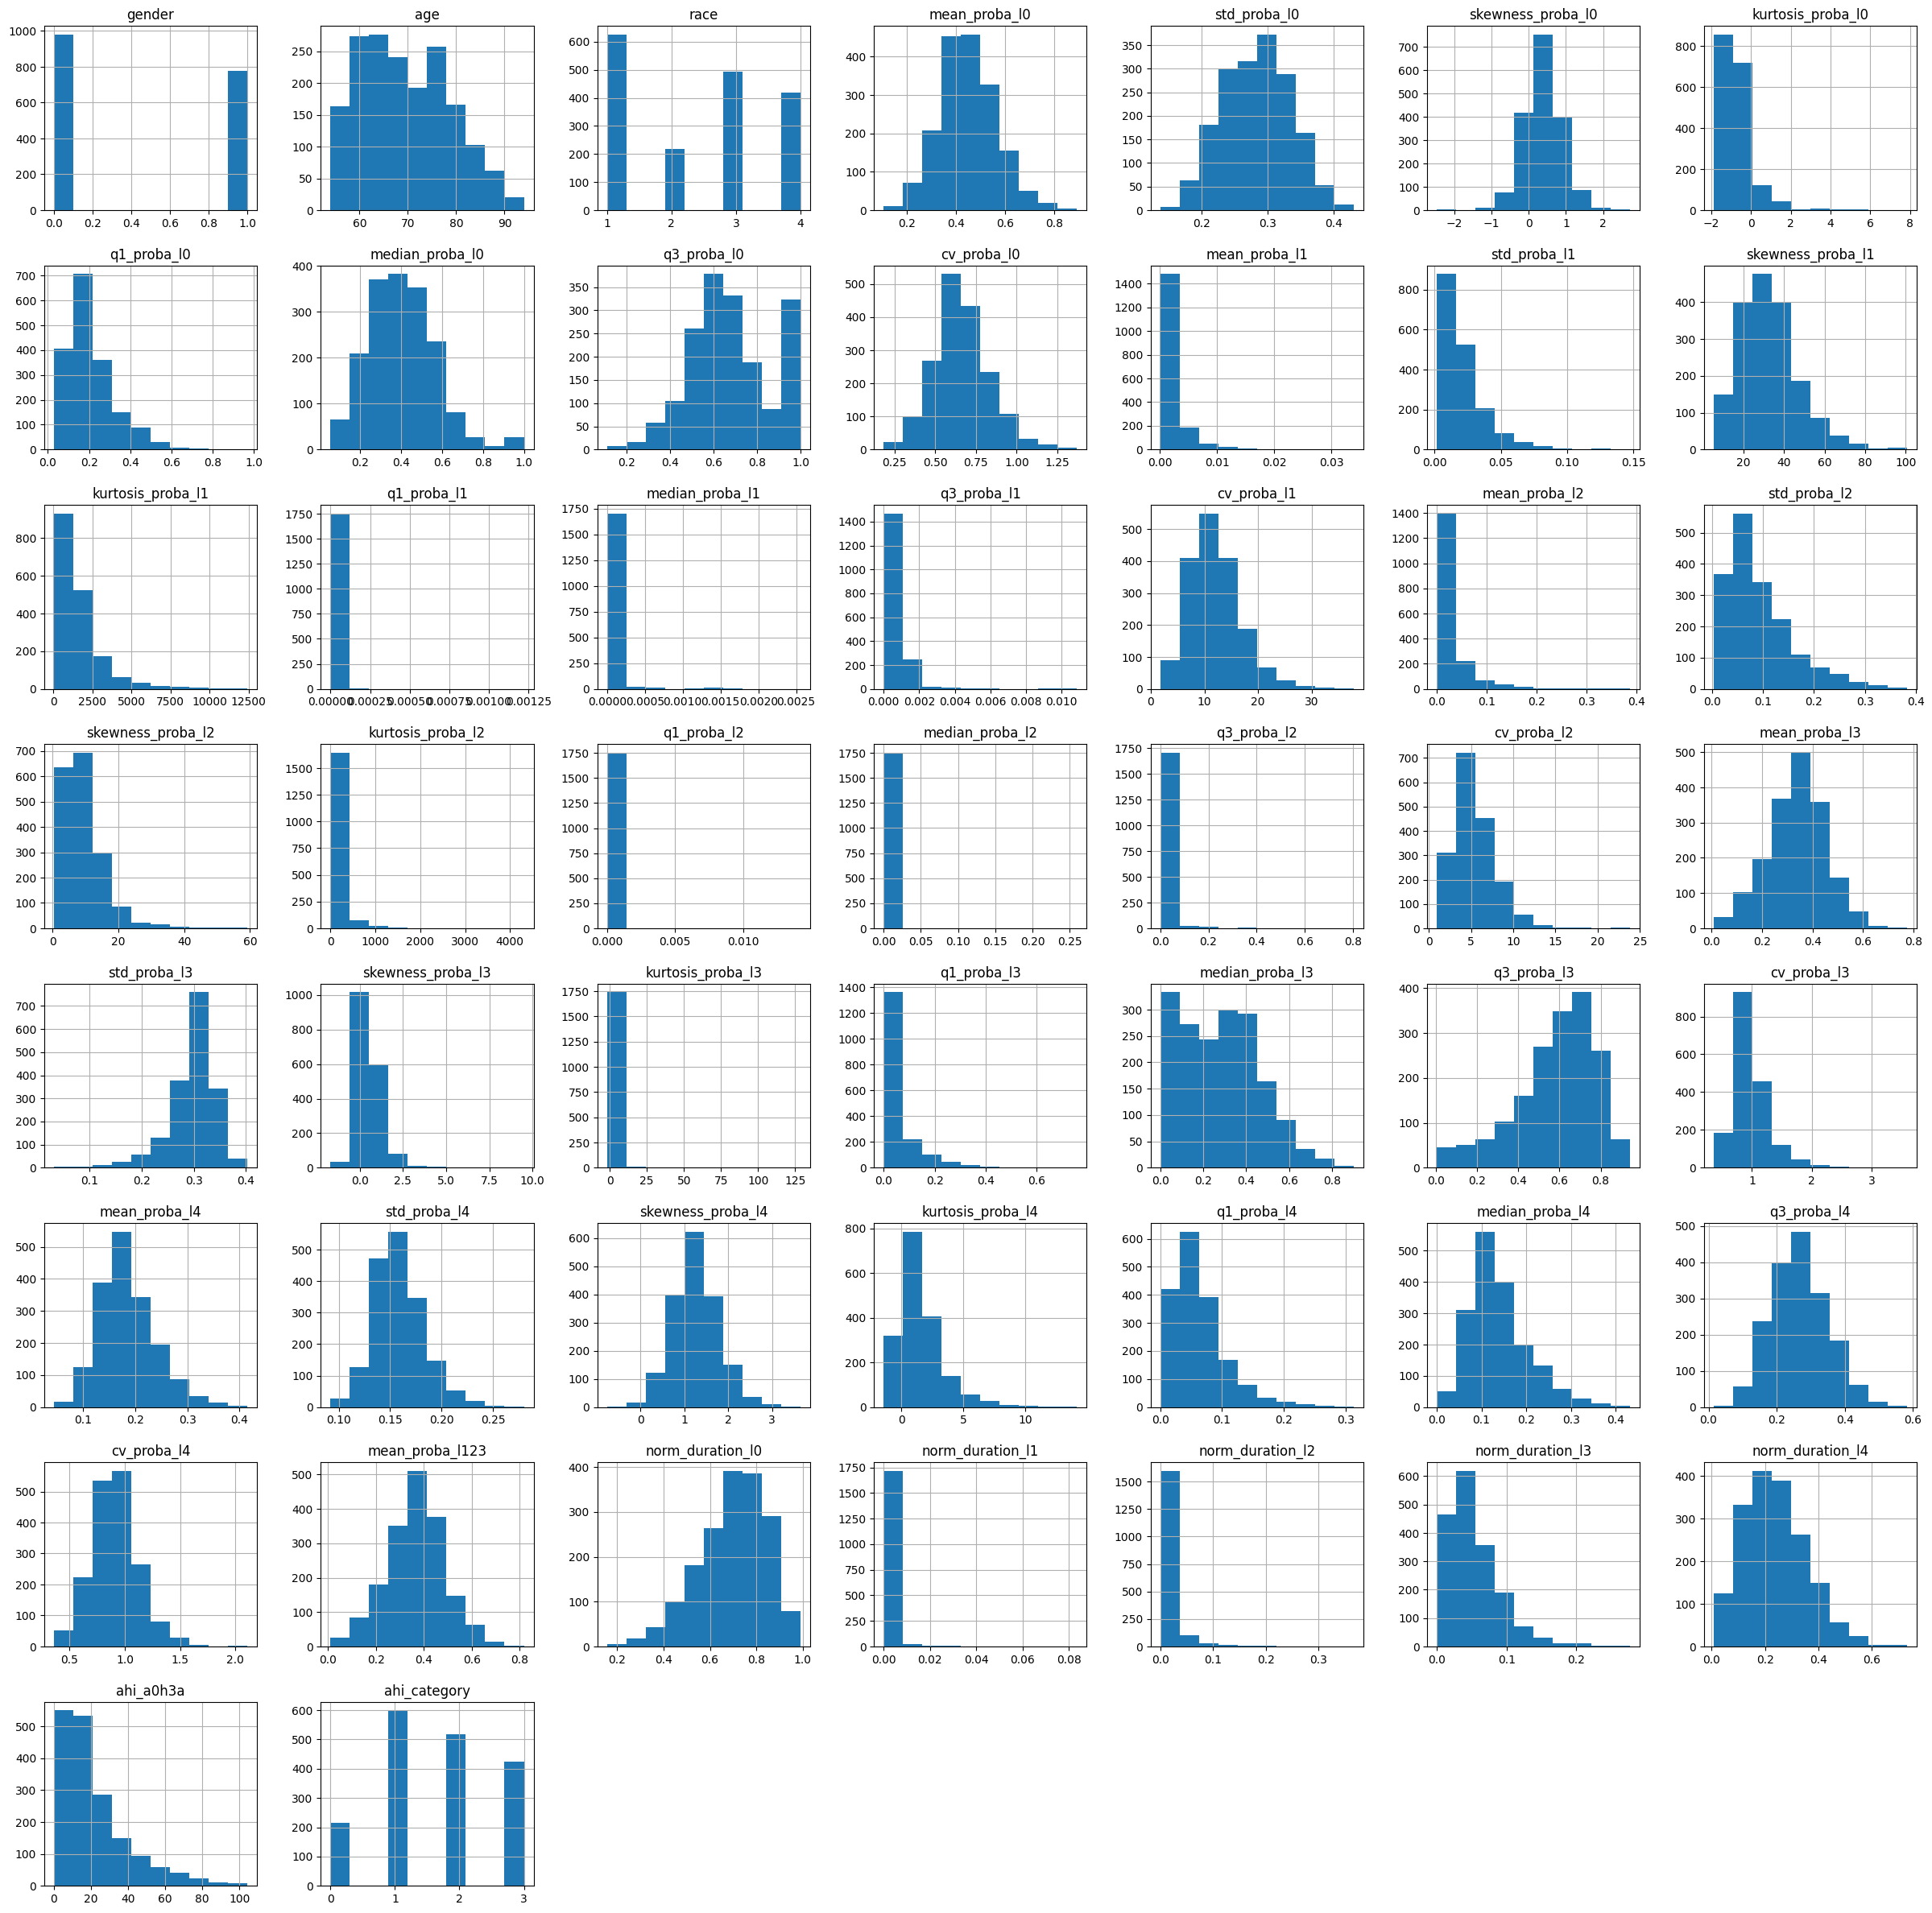

In [4]:
meta_df = pd.read_csv(PATH_TO_META_MODEL.joinpath("meta_df.csv"), index_col=0)
print(meta_df.shape)

meta_df["mean_proba_l123"] = meta_df["mean_proba_l1"] + meta_df["mean_proba_l2"]+ meta_df["mean_proba_l3"]

out_columns = ["norm_duration_l0", "norm_duration_l1", "norm_duration_l2", "norm_duration_l3", "norm_duration_l4",
             "ahi_a0h3a", "ahi_category"]
in_columns = [c for c in meta_df.columns if c not in out_columns]

fourier_columns = [c for c in in_columns if "_f" in c and 'l' in c]
stat_columns = [c for c in in_columns if c not in fourier_columns]

if not USE_FOURIER_COMPONENTS and len(fourier_columns) > 0:
    meta_df.drop(fourier_columns, axis=1, inplace=True)
    in_columns = [c for c in meta_df.columns if c not in out_columns]

fig = plt.figure(figsize=(30,30))
meta_df[[*stat_columns, *out_columns]].hist(figsize=(30,30))
plt.show()


Top 8 features with largest absolute (positive or negative) correlation with ahi_a0h3a: ['std_proba_l4' 'q3_proba_l4' 'std_proba_l2' 'mean_proba_l4'
 'mean_proba_l2' 'cv_proba_l2' 'skewness_proba_l2' 'median_proba_l4']


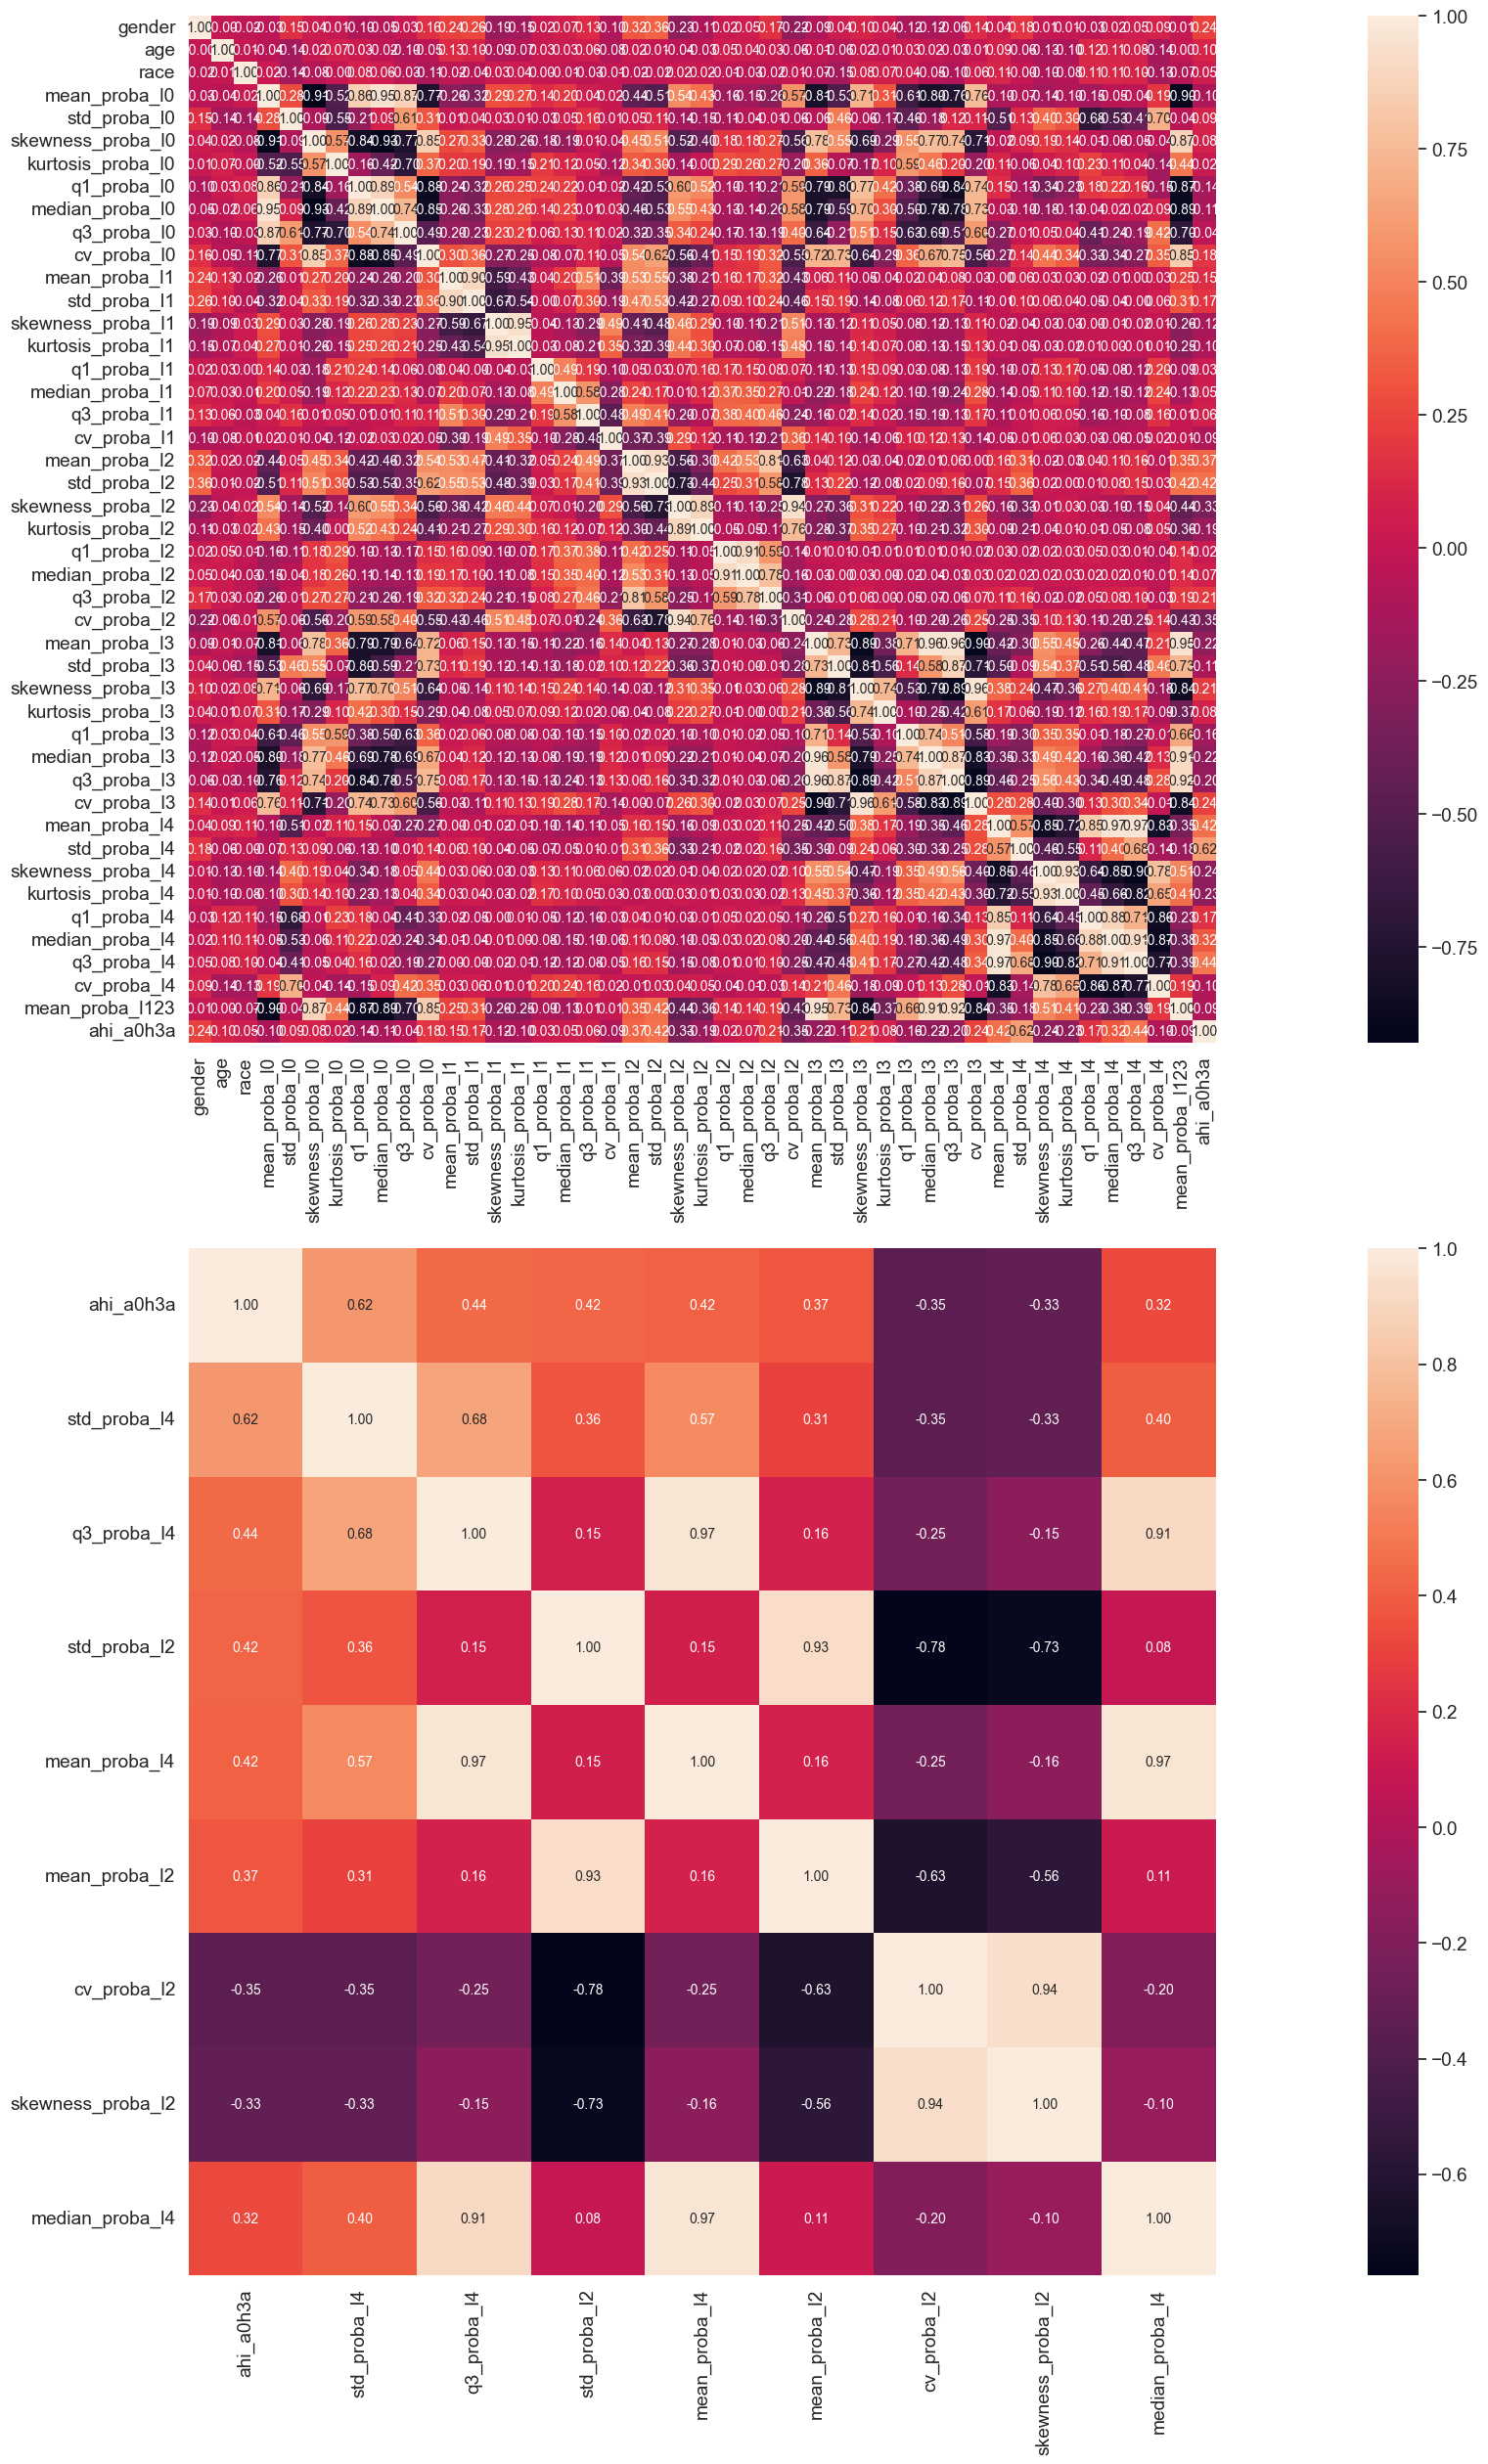

In [5]:
def plot_correl_matrix(df, target, k=8):
    # k = features to select
    corrmat = df.corr()
    sns.set(font_scale=1.25)
    if k>0 and k<len(df.columns):
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(40,30))
        
        sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=df.columns.values, xticklabels=df.columns.values, ax=ax[0])

        largest_abs_corr_cols = corrmat.abs().nlargest(k+1, target)[target].index
        cm = np.corrcoef(df[largest_abs_corr_cols].values.T)

        sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=largest_abs_corr_cols.values, xticklabels=largest_abs_corr_cols.values, ax=ax[1]) 

        largest_abs_corr_cols = np.delete(largest_abs_corr_cols.values, 0) # remove target
        print(f"Top {k} features with largest absolute (positive or negative) correlation with {target}: {largest_abs_corr_cols}")
    else:
        sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=df.columns.values, xticklabels=df.columns.values)

def classification_performance(y_true, y_hat, test=True, plot_confusion=True, target_labels=None, normalize=None):
    train_test =  "test" if test else "train"
    accuracy = accuracy_score(y_true, y_hat)
    print(f"Accuracy ({train_test})  %0.1f%% " % ( accuracy * 100))
    if plot_confusion:
        
        cm = confusion_matrix(y_true, y_hat,normalize=normalize)
        #print(cm)
        if not target_labels:
            df_cm = pd.DataFrame(cm)
        else:    
            df_cm = pd.DataFrame(cm, index = target_labels,
                            columns = target_labels)
        plt.figure(figsize = (7,5))
        sns.set(font_scale=1) # for label size
        if normalize:
            sns.heatmap(df_cm, annot=True, fmt=".2f",)
        else:
            sns.heatmap(df_cm, annot=True, fmt="d")   
        plt.xlabel("Predicted")
        plt.ylabel("True")    
        plt.show()
    return accuracy

target="ahi_a0h3a"
plot_correl_matrix(meta_df[[*in_columns, target]], target=target)

## Train test split

In [6]:
meta_train_df, meta_test_df = train_test_split(meta_df, test_size=TEST_SIZE, random_state=33,
                                                shuffle=True, stratify=meta_df["ahi_category"])

X_train_df: pd.DataFrame = meta_train_df[in_columns]
Y_train_df: pd.DataFrame = meta_train_df[out_columns]

X_test_df: pd.DataFrame = meta_test_df[in_columns]
Y_test_df: pd.DataFrame = meta_test_df[out_columns]

## Oversampling:

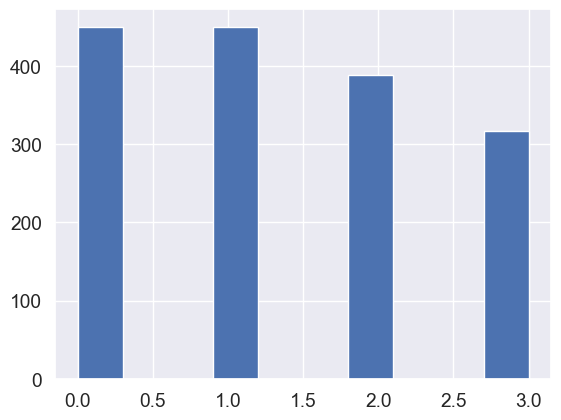

In [7]:
if OVER_SAMPLING:
    ros = RandomOverSampler(sampling_strategy="minority", random_state=33)

    X_train_df, _ = ros.fit_resample(meta_train_df[in_columns], meta_train_df["ahi_category"])
    inds = ros.sample_indices_
    extra_inds = inds[len(meta_train_df):]
    Y_train_df = pd.concat([meta_train_df[out_columns], meta_train_df[out_columns].iloc[extra_inds, :]], axis=0, ignore_index=True)

    Y_train_df["ahi_category"].hist()

else:
    X_train_df: pd.DataFrame = meta_train_df[in_columns]
    Y_train_df: pd.DataFrame = meta_train_df[out_columns]   

In [8]:
X_test_df: pd.DataFrame = meta_test_df[in_columns]
Y_test_df: pd.DataFrame = meta_test_df[out_columns]

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

Y_train_clas = Y_train_df["ahi_category"].to_numpy().ravel()
Y_test_clas = Y_test_df["ahi_category"].to_numpy().ravel()

Y_train_reg = Y_train_df.drop("ahi_category", axis=1, inplace=False).to_numpy()
Y_test_reg = Y_test_df.drop("ahi_category", axis=1, inplace=False).to_numpy()

## Standardization:

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Classification

### Model Selection

In [ ]:
models = [LogisticRegression(random_state=33, solver="newton-cg"), RandomForestClassifier(random_state=33), SVC(random_state=33), XGBClassifier(seed=33)]

for model in models:
    scores = cross_validate(estimator=model, X=X_train, y=Y_train_clas, scoring="accuracy", cv=5)
    acc = np.mean(scores["test_score"])
    print(f"{model} -> {100*acc:2.2f}%")

LogisticRegression(random_state=33, solver='newton-cg') -> 49.81%
RandomForestClassifier(random_state=33) -> 63.08%
SVC(random_state=33) -> 53.55%
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) -> 63.20%


#### Logistic

In [ ]:
model = LogisticRegression(random_state=33)

parameters = {'multi_class':['auto'],
              'penalty': ['l1', 'l2'],
              'C': np.linspace(0.2,1.0, num=10, endpoint=True),
              'solver': ['liblinear', 'newton-cg', 'saga']}
clf = GridSearchCV(model, parameters, cv=5, scoring="accuracy", refit=True)
clf.fit(X_train, Y_train_clas)

print(clf.best_score_)
best_logistic = clf.best_estimator_
best_logistic_params = clf.best_params_
best_logistic_params

g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

0.5006443373773728


{'C': 0.2888888888888889,
 'class_weight': 'balanced',
 'multi_class': 'auto',
 'penalty': 'l2',
 'solver': 'newton-cg'}

Accuracy (test)  46.9% 


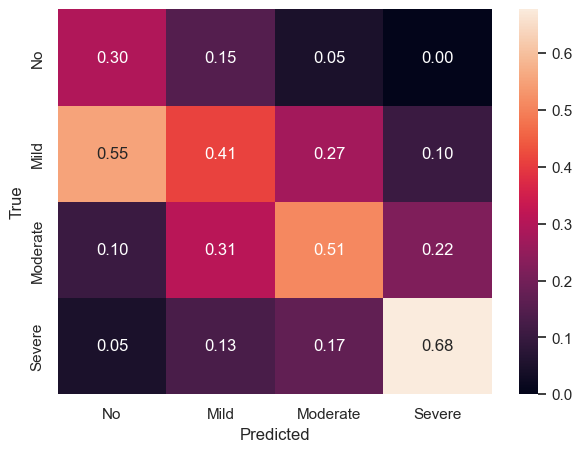

0.46924829157175396

In [ ]:
classification_performance(Y_test_clas, best_logistic.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

Test accuracy: 46.92%


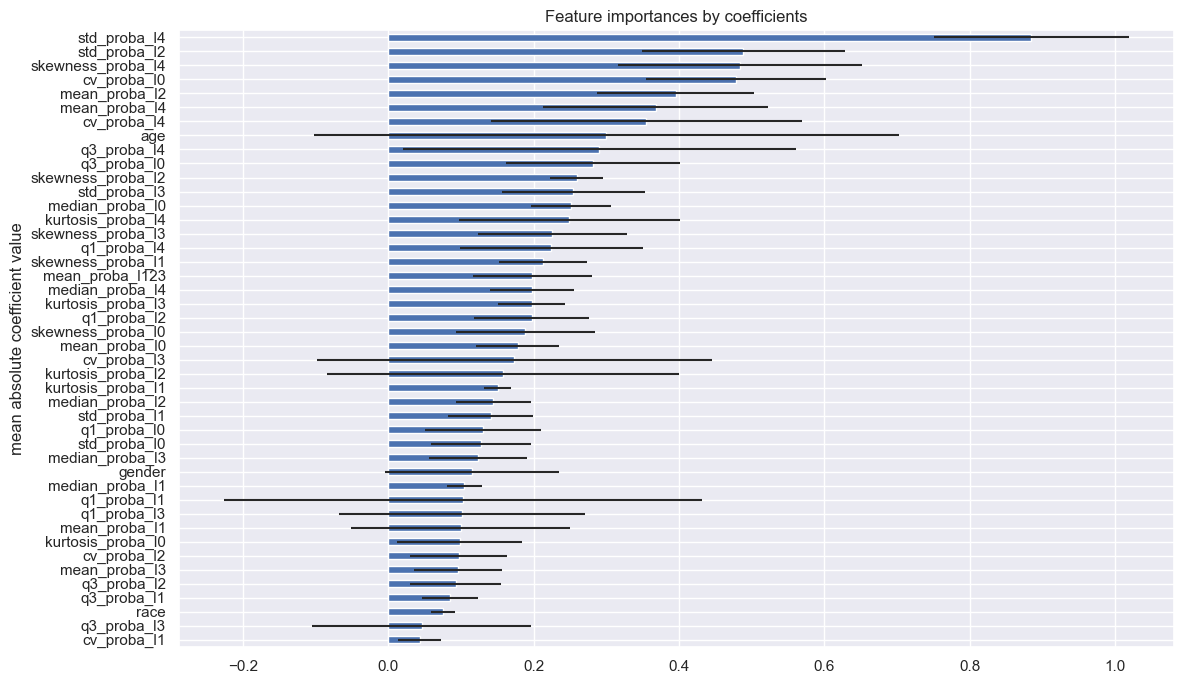

In [ ]:
print(f"Test accuracy: {100*accuracy_score(Y_test_clas, best_logistic.predict(X_test)):.2f}%")


importances = np.mean(np.abs(best_logistic.coef_), axis=0)
std = np.std(np.abs(best_logistic.coef_), axis=0)
importances_s = pd.Series(importances, index=in_columns).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12,7))
importances_s.plot.barh(xerr=std, ax=ax)
ax.set_title(f"Feature importances by coefficients")
ax.set_ylabel("mean absolute coefficient value")
fig.tight_layout()

### SVC

In [ ]:
model = SVC(random_state=33)

parameters = {'degree': [2, 3, 4],
              'gamma': ["scale", "auto"],
              'C': np.linspace(0.1,1.0, num=20, endpoint=True),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
clf = GridSearchCV(model, parameters, cv=5, scoring="accuracy", refit=True)
clf.fit(X_train, Y_train_clas)

print(clf.best_score_)
best_svm = clf.best_estimator_
best_svm_params = clf.best_params_
best_svm_params

0.5373676979934598


{'C': 1.0, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

Accuracy (test)  44.4% 


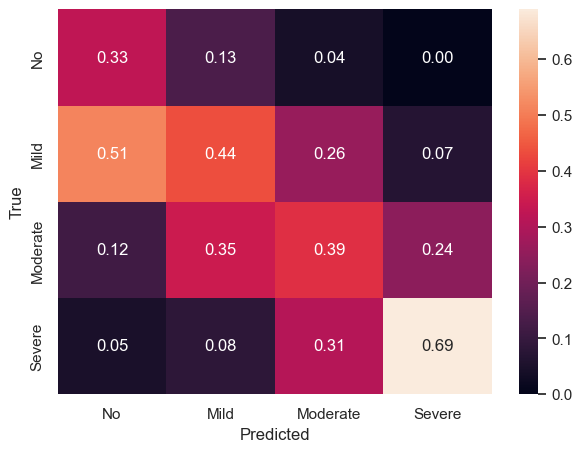

0.44419134396355353

In [ ]:
classification_performance(Y_test_clas, best_svm.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

### Random Forest

In [ ]:
rf_clas = RandomForestClassifier(random_state=33)

parameters = {'n_estimators':[100], 
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth':[5, 7, 10],
              'min_samples_split': [2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3, 4],
              'max_features': ("sqrt", 'log2')}
clf = GridSearchCV(rf_clas, parameters, cv=5, scoring="accuracy", refit=True)
clf.fit(X_train, Y_train_clas)

print(clf.best_score_)
best_rfc = clf.best_estimator_
best_params = clf.best_params_
best_params

0.630781138135872


{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

Accuracy (test)  45.3% 


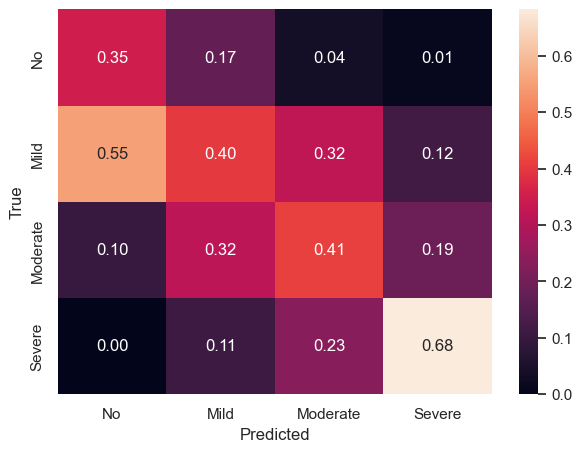

0.4533029612756264

In [ ]:
classification_performance(Y_test_clas, best_rfc.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

Test accuracy: 45.33%


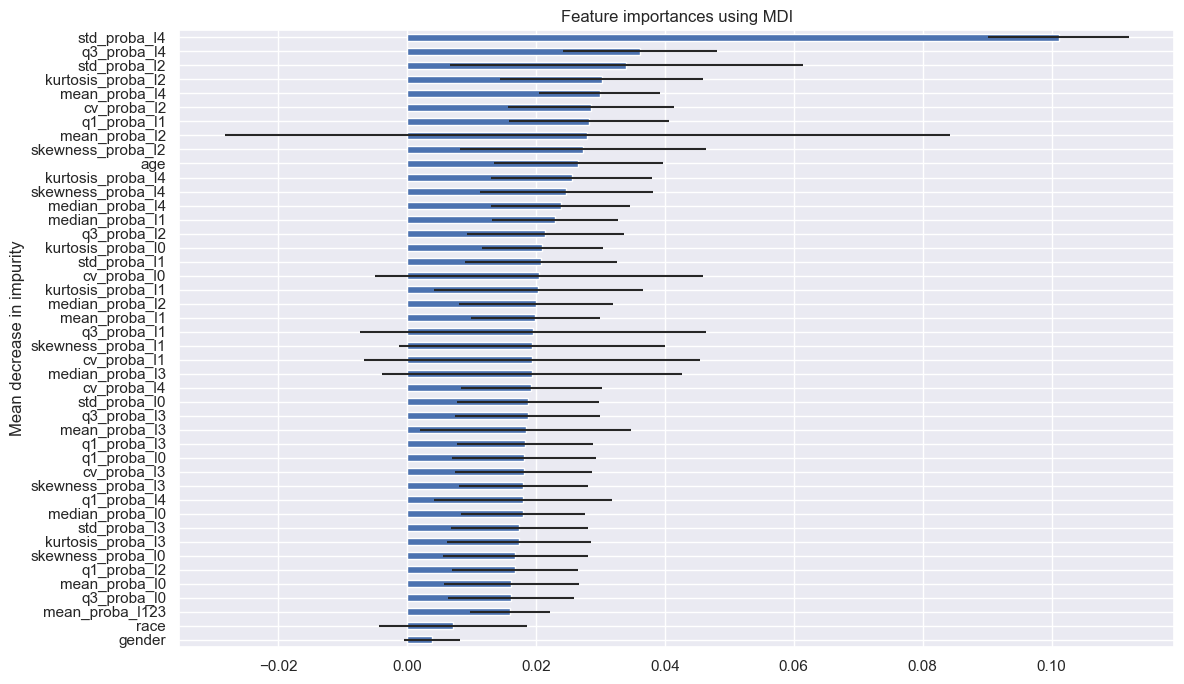

In [ ]:
print(f"Test accuracy: {100*accuracy_score(Y_test_clas, best_rfc.predict(X_test)):.2f}%")

importances = best_rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rfc.estimators_], axis=0)
forest_importances = pd.Series(best_rfc.feature_importances_, index=in_columns).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12,7))
forest_importances.plot.barh(xerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Regression

In [ ]:
Y_train_reg.shape

(1606, 6)

In [11]:
Y_scaler = StandardScaler()
Y_scaler.fit(Y_train_reg)
Y_train_reg_scaled = Y_scaler.transform(Y_train_reg)

models = {"lr": LinearRegression(), "ridge": Ridge(), "svr": SVR(), "rf": RandomForestRegressor(random_state=33), "xgb": XGBRegressor(seed=33)}

cv_splitter = [(train_indices, validation_indices) for (train_indices, validation_indices) in StratifiedKFold(n_splits=5).split(X_train, y=Y_train_clas)]

for name, model in models.items():
    print(f"Model: {name}")
    for i, var in enumerate(out_columns[0:6]):
        scores = cross_validate(estimator=model, X=X_train, y=Y_train_reg_scaled[:,i], scoring='r2', cv=cv_splitter)["test_score"]
        print(f"Target: {var} -> Mean score: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}, CV: {100*np.std(scores)/abs(np.mean(scores)):2.2f}%")

Model: lr
Target: norm_duration_l0 -> Mean score: 0.5107, Std: 0.1143, CV: 22.37%
Target: norm_duration_l1 -> Mean score: -0.0743, Std: 0.6507, CV: 876.29%
Target: norm_duration_l2 -> Mean score: 0.0451, Std: 0.2401, CV: 532.07%
Target: norm_duration_l3 -> Mean score: -0.2794, Std: 0.7492, CV: 268.18%
Target: norm_duration_l4 -> Mean score: 0.5279, Std: 0.0552, CV: 10.45%
Target: ahi_a0h3a -> Mean score: 0.5123, Std: 0.0363, CV: 7.09%
Model: ridge
Target: norm_duration_l0 -> Mean score: 0.5239, Std: 0.0944, CV: 18.02%
Target: norm_duration_l1 -> Mean score: -0.1209, Std: 0.7225, CV: 597.77%
Target: norm_duration_l2 -> Mean score: 0.0423, Std: 0.2385, CV: 563.27%
Target: norm_duration_l3 -> Mean score: -0.2468, Std: 0.6857, CV: 277.83%
Target: norm_duration_l4 -> Mean score: 0.5321, Std: 0.0483, CV: 9.08%
Target: ahi_a0h3a -> Mean score: 0.5221, Std: 0.0213, CV: 4.08%
Model: svr
Target: norm_duration_l0 -> Mean score: 0.5662, Std: 0.0578, CV: 10.21%
Target: norm_duration_l1 -> Mean scor

KeyboardInterrupt: 

### Ridge

In [130]:
model = Ridge(random_state=33)

parameters = {'alpha': np.linspace(0.0,20.0, num=100, endpoint=True)}
clf = GridSearchCV(model, parameters, cv=cv_splitter, scoring="r2", refit=True)
clf.fit(X_train, Y_train_reg[:,5])

print(clf.best_score_)
best_ridge = clf.best_estimator_
best_ridge_params = clf.best_params_
best_ridge_params

g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.0533e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


0.5324217082415901


{'alpha': 9.8989898989899}

In [131]:
mdl = best_ridge
y_true = Y_test_reg[:,5]
y_hat = mdl.predict(X_test)

r2 = r2_score(y_true=y_true, y_pred=y_hat)
mae = mean_absolute_error(y_true=y_true, y_pred=y_hat)
rmse = mean_squared_error(y_true=y_true, y_pred=y_hat, squared=False)
y_mean = np.mean(y_true)

print(f"Test R^2: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"CV(RMSE): {100*rmse/y_mean:.2f}%")

Test R^2: 0.53
MAE: 8.68
CV(RMSE): 56.18%


### SVR

In [118]:
Y_scaler_ahi = StandardScaler()
Y_scaler_ahi.fit(Y_train_reg[:,5].reshape(-1,1))
Y_train_ahi_scaled = Y_scaler_ahi.transform(Y_train_reg[:,5].reshape(-1,1)).ravel()

model = SVR()

parameters = {'degree': [2, 3, 4],
              'gamma': ["scale", "auto"],
              'C': np.linspace(0.1,1.0, num=20, endpoint=True),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
clf = GridSearchCV(model, parameters, cv=cv_splitter, scoring="r2", refit=True)
clf.fit(X_train, Y_train_ahi_scaled)

print(clf.best_score_)
best_svr= clf.best_estimator_
best_svr_params = clf.best_params_
best_svr_params

0.5399964698209836


{'C': 1.0, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

In [127]:
y_hat = Y_scaler_ahi.inverse_transform(best_svr.predict(X_test).reshape(-1,1)).ravel()
y_true = Y_test_reg[:,5]


r2 = r2_score(y_true=y_true, y_pred=y_hat)
mae = mean_absolute_error(y_true=y_true, y_pred=y_hat)
rmse = mean_squared_error(y_true=y_true, y_pred=y_hat, squared=False)
y_mean = np.mean(y_true)

print(f"Test R^2: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"CV(RMSE): {100*rmse/y_mean:.2f}%")

Test R^2: 0.48
MAE: 8.90
CV(RMSE): 59.11%


### Random Forest Regression

In [120]:
model = RandomForestRegressor(random_state=33)

parameters = {'n_estimators':[100], 
              'max_depth':[10, 15, 20, 25, 30],
              'min_samples_split': [2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3, 4],
              'max_features': ("sqrt", 'log2')}

clf = GridSearchCV(model, parameters, cv=cv_splitter, scoring="r2", refit=True)
clf.fit(X_train, Y_train_reg[:,5])

print(clf.best_score_)
best_rfr = clf.best_estimator_
best_rfr_params = clf.best_params_
best_rfr_params

0.58996295415384


{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [128]:
mdl = best_rfr
y_true = Y_test_reg[:,5]
y_hat = mdl.predict(X_test)

r2 = r2_score(y_true=y_true, y_pred=y_hat)
mae = mean_absolute_error(y_true=y_true, y_pred=y_hat)
rmse = mean_squared_error(y_true=y_true, y_pred=y_hat, squared=False)
y_mean = np.mean(y_true)

print(f"Test R^2: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"CV(RMSE): {100*rmse/y_mean:.2f}%")

Test R^2: 0.46
MAE: 9.53
CV(RMSE): 59.86%


### XGBoost

In [17]:
model = XGBRegressor(seed=33)

parameters = {'eta': np.arange(0.1,0.51,0.1), 
              'gamma': [0, 0.05, 0.1],
              'max_depth':[3, 5, 6],
              'subsample': [0.7, 0.8, 0.9, 1.0],
              'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
              'colsample_bynode': [0.7, 0.8, 0.9, 1.0],
              'lambda': np.arange(0.1,1.1,0.1),
              'alpha': np.arange(0.1,1.1,0.1)
              }

clf = RandomizedSearchCV(model, parameters, n_iter=100, cv=cv_splitter, scoring="r2", refit=True, random_state=33)
clf.fit(X_train, Y_train_reg[:,5])

print(clf.best_score_)
best_xgbr = clf.best_estimator_
best_xgbr_params = clf.best_params_
best_xgbr_params